## Introduction

Image detection is a good entry point for learning about the use of neural networks, which I aim to learn more about in this project. The problem to be solved in my project is image detection (of handwritten digits, in this case) by using the branch of machine learning that deals with image detection. 

## Data Wrangling

I'll first read in the data and then check for any anomalies. The data exists, among other places, in a scikit-learn repository through Python, where I'll access it for convenience. I'll follow a sample approach provided on this site: http://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py. 

In [10]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

mnist = fetch_mldata('MNIST')
X = mnist.data.astype('float64')
y = mnist.target

In [ ]:
# CHECK UNDERSTANDING OF DATA READ IN, SHAPE, ETC.

In [5]:
print(X.shape) #70K rows w/ 780 example digits in each row
print(y.shape) #vector of 70K example digits
print(np.unique(y))

(70000, 780)
(70000,)
[0 1 2 3 4 5 6 7 8 9]


# Model Building and Analysis: Logistic Regression

As a baseline comparison to the coming neural network, I will first run a logistic regression. We can use the results here to compare performance against that of the neural network. Logistic regression is commonly used in binary classification problems but can also be used for multinomial ones like this one, in which we are attempting to classify multiple digits. It works by identifying features that have the greatest predictive value (mathematically) on the outcome of interest. 

To start, I will split the data into training and test sets. The training set will be used for model building, with the test data set aside in advance to evaluate how well the model then generalizes. I'll also scale the data using standard scaling, which sets a mean of zero and a variance of one unit. This step makes computations more stable. 

In [27]:
from sklearn.preprocessing import StandardScaler

# train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# standard scaling (mean of zero, unit variance) 
scaler = StandardScaler(with_mean = False) #with_mean parameter accommodates sparse matrices 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Next, I will run an initial model with tuned parameters. The L1 penalty sometimes performs better than the L2 with sparse matrices, but frankly, I have not been able to get Python to acknowledge the "saga" solved that is supposed to work in conjunction with L1. (An error message appears saying that saga isn't an option for logistic regression, despite the documentation suggesting otherwise.) As a secondary option, I will use the "sag" solver with L2 regularization, which is another acceptable pairing for multinomial classifications. 

I will also tweak the tolerance (tol in the code) in the model, which expedites the convergence of the algorithm with a large amount of data like we have here. The default tolerance is .0001, so we don't want to deviate too far from that, or the model may not generalize well. 

In [52]:
# logistic regression on training data 

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C_grid = {'C': [0.001, 0.1, 1, 10, 100]}
clf_grid = GridSearchCV(LogisticRegression(multi_class='multinomial', solver='sag', tol=.01, penalty='l2'), 
                        C_grid, cv = 5, scoring = 'accuracy')
clf_grid.fit(X_train, y_train)
print(clf_grid.best_params_, clf_grid.best_score_)

{'C': 100} 0.917267857143


In [53]:
 #check performance on test set
clf_grid_test = LogisticRegression(C = clf_grid.best_params_['C'], multi_class='multinomial', solver='sag', tol=0.1)
clf_grid_test.fit(X_train, y_train)
accuracy_score(clf_grid_test.predict(X_test), y_test)

0.88707142857142862

For a more granular look at the model's performance on the test data, a classification report will show how well it predicted each digit. The aggregate accuracy score above and the metrics below indicate a strong model overall, as precision and recall are both well above .5 (the equivalent of random guessing) for each digit. 

For comparison, the next table shows digit-level performance for the training data. As expected, the model performs a bit better here, but not so much as to indicate overfitting. 

In [ ]:
# CLASSIFICATION REPORT (SEE INDIVIDUAL NOS.) LOOK SLIGHTLY BETTER FOR TEST DATA (HAPPENS IN RF, TOO)

In [54]:
print(classification_report(clf_grid_test.predict(X_train), y_train))

             precision    recall  f1-score   support

          0       0.95      0.93      0.94      5637
          1       0.96      0.91      0.93      6573
          2       0.85      0.89      0.87      5350
          3       0.86      0.86      0.86      5666
          4       0.90      0.90      0.90      5494
          5       0.80      0.86      0.83      4767
          6       0.93      0.92      0.92      5584
          7       0.89      0.91      0.90      5785
          8       0.82      0.82      0.82      5521
          9       0.86      0.84      0.85      5623

avg / total       0.89      0.89      0.89     56000



In [55]:
print(classification_report(clf_grid_test.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.95      0.94      0.95      1386
          1       0.97      0.91      0.94      1722
          2       0.85      0.88      0.87      1331
          3       0.86      0.85      0.86      1492
          4       0.91      0.91      0.91      1368
          5       0.80      0.84      0.82      1088
          6       0.93      0.92      0.93      1392
          7       0.88      0.92      0.90      1362
          8       0.82      0.83      0.82      1337
          9       0.88      0.85      0.86      1522

avg / total       0.89      0.89      0.89     14000



Finally, we'll look at a heat map to visualize the performance of the model. The heat map is based on a confusion matrix, which captures the predicted-actual pairings for each digit. Each row/column represents a digit, in order from zero to nine. 

In [56]:
# confusion matrix for each digit 
y_pred = clf_grid_test.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1309    0   13    8    1   14   15    0   19    3]
 [   0 1572    7    6    2    7    5    1   19    1]
 [  14   13 1177   36   23    1   31   22   57    6]
 [   8   10   46 1273    2   55   13   18   31   25]
 [   1   12   10    0 1240    6   14    5   16   61]
 [  13   16    9   69   14  919   24   11   56   23]
 [  12   21   19    1    6   19 1282    1   12    0]
 [   9   24   15   12   19    2    1 1249    3   85]
 [  10   44   25   52    5   61    6   12 1109   29]
 [  10   10   10   35   56    4    1   43   15 1289]]


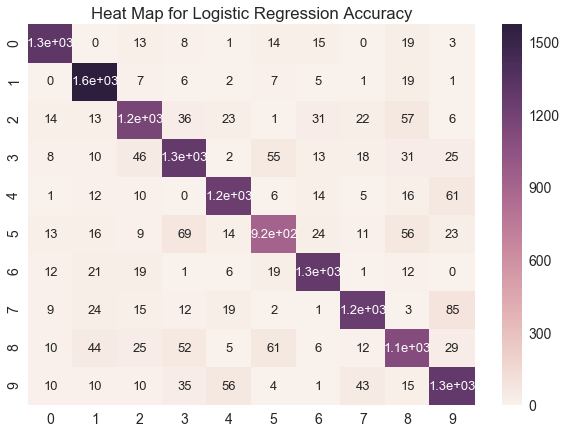

In [57]:
# heat map 
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #set label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 13}) #set font size
plt.title('Heat Map for Logistic Regression Accuracy')
plt.show() 

# Model Building and Analysis: Random Forest

For an additional comparison to the coming neural network, I will create a random forest. The structure of this model is notably different from a logistic regression, so its output will be valuable for comparison to the neural network as well. In particular, the random forest makes classification decisions based on a decision trees that rely on series of split points (e.g., where to draw the line between a 2 and a 3) of the different variables. The random forest randomly generates many decision trees to harness the benefits of an ensemble model. 

In [29]:
# build/fit model with random forest 
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state = 17) 
model_rf = clf_rf.fit(X_train, y_train)

In [30]:
# model accuracy on test data
print(model_rf.score(X_test, y_test))

0.946428571429


In [31]:
# classification report
print(classification_report(clf_rf.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.98      0.97      0.97      1402
          1       0.98      0.98      0.98      1628
          2       0.96      0.92      0.94      1435
          3       0.93      0.92      0.93      1492
          4       0.96      0.94      0.95      1398
          5       0.93      0.92      0.93      1156
          6       0.96      0.97      0.97      1348
          7       0.95      0.96      0.95      1405
          8       0.90      0.93      0.92      1307
          9       0.91      0.94      0.93      1429

avg / total       0.95      0.95      0.95     14000



To improve the model's stability and ability to generalize, I will work on tuning the parameters of the random forest algorithm. This step will help determine the optimal method for using the maximum number of features without overfitting. The performance metrics may drop some in turn, but it's a worthwhile trade-off to help the model generalize effectively. 

In [ ]:
# CHECK VALIDITY OF PARAMETER TUNING HERE
 # ADJUST MARKDOWN, RESULTS, ETC. IF CHANGES MADE 

In [32]:
# updated random forest model 
new_rf = RandomForestClassifier(random_state = 64, n_estimators = 20, max_features = 'sqrt', max_depth = 5)
new_clf = new_rf.fit(X_train, y_train)

# accuracy score and classification report with respect to test data                               
print(new_clf.score(X_test, y_test))
print(classification_report(clf_rf.predict(X_test), y_test))

0.84
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      1402
          1       0.98      0.98      0.98      1628
          2       0.96      0.92      0.94      1435
          3       0.93      0.92      0.93      1492
          4       0.96      0.94      0.95      1398
          5       0.93      0.92      0.93      1156
          6       0.96      0.97      0.97      1348
          7       0.95      0.96      0.95      1405
          8       0.90      0.93      0.92      1307
          9       0.91      0.94      0.93      1429

avg / total       0.95      0.95      0.95     14000



Through some quick trial and error, I determined that using both the square root and log2 options for the max_features parameter produce nearly the same results, which makes sense mathematically for 10 features. I'll leave the default of square root in place for this parameter. For the number of estimators (or trees), I tested 10, 20, and 30, which all produced similar results. With a relatively small number of features, 20 seems like a good middle ground to limit error while still having enough randomization in the ensemble. Model performance also held with a depth of 5 levels in the trees, so I will keep this relatively low value to reduce the potential for overfitting. 

In [33]:
# confusion matrix for each digit 
y_pred_rf = new_clf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

[[1305    2    5   13    1    4   19    1   31    1]
 [   0 1591    5    5    1    1    3    2    7    5]
 [  13   48 1152   35   21   10   34   28   29   10]
 [  14   48   41 1175   14   53   16   33   29   58]
 [   4   11    7    4 1080    8   37   24   22  168]
 [  30   53    4  158   31  767   34   29   23   25]
 [  26   23   16    2   18   15 1251    4   18    0]
 [   4   49   17    2   26    0    3 1240   11   67]
 [   5   85   36   69   19   27   40    5 1016   51]
 [  11   15   15   25   90   15   12   87   20 1183]]


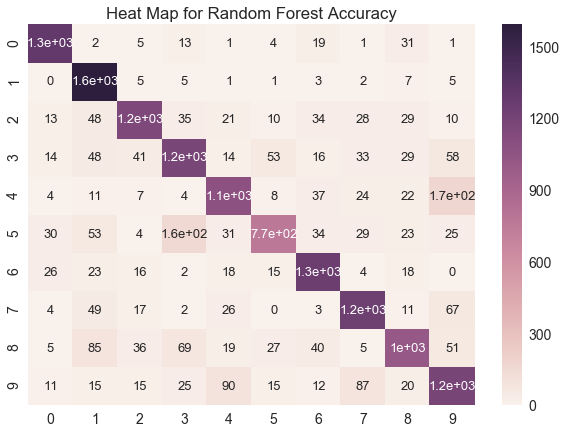

In [48]:
# heat map 
df_rf = pd.DataFrame(cm_rf)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) 
sns.heatmap(df_rf, annot=True, annot_kws={"size": 13}) 
plt.title('Heat Map for Random Forest Accuracy')
plt.show() 

The random forest model outperforms the logistic regression based on accuracy scores and the confusion matrix. It will be helpful to have two models with different performances when making comparisons to the neural network, which I'll proceed with now. 

# Model Building and Analysis: Neural Network

For parameters, I'll start with 'adam' as the solver because I understand it to be a good compromise of computational demand and advanced weighting. (It is also the default in scikit-learn.) I will use the logistic activation function as well. It oftern performs better in classification problems because small changes in variable weights and bias cause only a small change in its output. Finally, to determine the best alpha value (L2 regularization penalty), I will use cross-validation. The L2 penalty is important for striking the right balance between variance and bias so that the model will generalize appropriately. 

In [40]:
# cross-validation to choose best alpha
alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1]}
mlp_grid = GridSearchCV(MLPClassifier(solver='adam', activation='logistic', random_state=1), 
                        alphas, cv = 5, scoring = 'accuracy')
mlp_grid.fit(X_train, y_train)
print(mlp_grid.best_params_, mlp_grid.best_score_)

{'alpha': 0.01} 0.969607142857


In [41]:
# neural network model with best alpha
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='adam', alpha=.01, activation='logistic', random_state=1)
mlp.fit(X, y)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 0.929964
Test set score: 0.931571


In [ ]:
# WHY IS TEST SCORE HIGHER? (shows up in individual digits of classification reports, too)

In [44]:
# classification report for training data
print(classification_report(mlp.predict(X_train), y_train))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96      5520
          1       0.97      0.98      0.98      6182
          2       0.95      0.90      0.92      5934
          3       0.93      0.91      0.92      5782
          4       0.88      0.97      0.92      4967
          5       0.93      0.86      0.89      5580
          6       0.96      0.94      0.95      5626
          7       0.97      0.91      0.94      6249
          8       0.84      0.95      0.89      4838
          9       0.90      0.92      0.91      5322

avg / total       0.93      0.93      0.93     56000



In [43]:
# classification report for test data
print(classification_report(mlp.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.96      0.97      0.97      1376
          1       0.97      0.99      0.98      1599
          2       0.95      0.89      0.92      1478
          3       0.93      0.90      0.92      1521
          4       0.89      0.97      0.93      1255
          5       0.94      0.85      0.89      1276
          6       0.96      0.95      0.95      1392
          7       0.96      0.91      0.94      1499
          8       0.84      0.95      0.90      1196
          9       0.90      0.94      0.92      1408

avg / total       0.93      0.93      0.93     14000



In [45]:
# confusion matrix for each digit 
y_pred_mlp = mlp.predict(X_test)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print(cm_mlp)

[[1333    0   11    5    0   10   13    2    8    0]
 [   0 1576   13    5    4    5    4    6    5    2]
 [   5    0 1310   24    1    1   13   17    8    1]
 [   3    1   37 1374    0   25    5   14   11   11]
 [   2    4   22    3 1218   28   11   20   10   47]
 [   5    0    8   29    1 1082   14    4    4    7]
 [   5    3   29    1    3   10 1319    1    2    0]
 [   5    3   16    3    2    8    0 1366    1   15]
 [   8   11   28   49    1   91   12    8 1142    3]
 [  10    1    4   28   25   16    1   61    5 1322]]


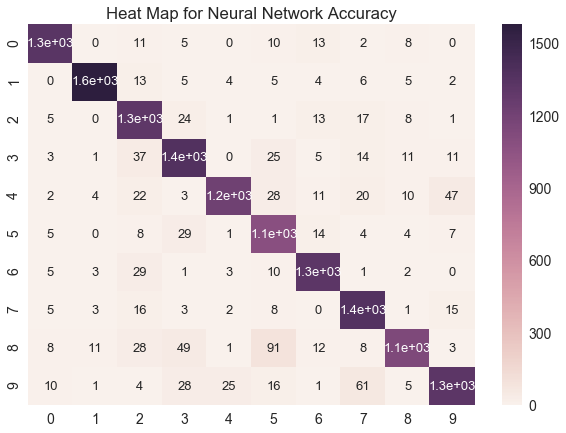

In [47]:
# heat map for neural network
df_mlp = pd.DataFrame(cm_mlp)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) 
sns.heatmap(df_mlp, annot=True, annot_kws={"size": 13}) 
plt.title('Heat Map for Neural Network Accuracy')
plt.show() 

In [ ]:
# DISCUSS RESULTS WHEN METHODOLOGY VALIDATED 


In [10]:
import numpy as np
import gzip
import pickle #converts object hierarchy into byte stream

def load_mnist():
    file = gzip.open('mnist.pkl.gz', 'rb') #read in in binary mode
    train, test = pickle.load(file)
    file.close()
    return (train, test)

The next function creates training and test datasets that will be easier to process. The initial training data is a list of 50,000 (x, y) tuples, where x is 784-dimensional (from 28x28 pixels) array of input image and y is a ten-dimensional array capturing the corresponding classification (digit value). The initial test data has the same structure but is a list of 10,000 tuples. 

In [11]:
def data_wrapper():
    train, test = load_mnist()
     #reshape first value (x) in each training tuple into 784D (28x28 pixels) vector
    train_inputs = [np.reshape(x, (784, 1)) for x in train[0]] 
    train_results = [vectorized_result(y) for y in train[1]]
    train_data = zip(train_inputs, train_results)
#validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
#validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in test[0]]
    test_data = zip(test_inputs, test[1])
    return (train_data, test_data) #validation_data,

In [ ]:
# see to-do list before proceeding -- may not need vectorized_result and beyond

The third formula converts a 0-9 digit into a corresponding desired output from the neural network using 1 as a binary marker among zeroes otherwise. It sets up a one-versus-many method of evaluation for the algorithm, in which a yes-or-no decision is made for each potential digit. (For example, in a correct prediction of a 6, the algorithm would choose "no" for the other nine digits and "yes" for 6. The gestalt is also the reason we have a 10-dimensional unit vector -- one dimension for each digit. 

In [12]:
def vectorized_result(j):
    tenD_uv = np.zeros((10, 1)) #create 10D unit vector
    tenD_uv[j] = 1.0 #put 1 in jth position
    return tenD_uv

In [ ]:
# next step: initialize a Network object??